In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/APOTS_2019/train.csv")
test = pd.read_csv("/content/drive/MyDrive/APOTS_2019/test.csv")

## 이미지 데이터 전처리

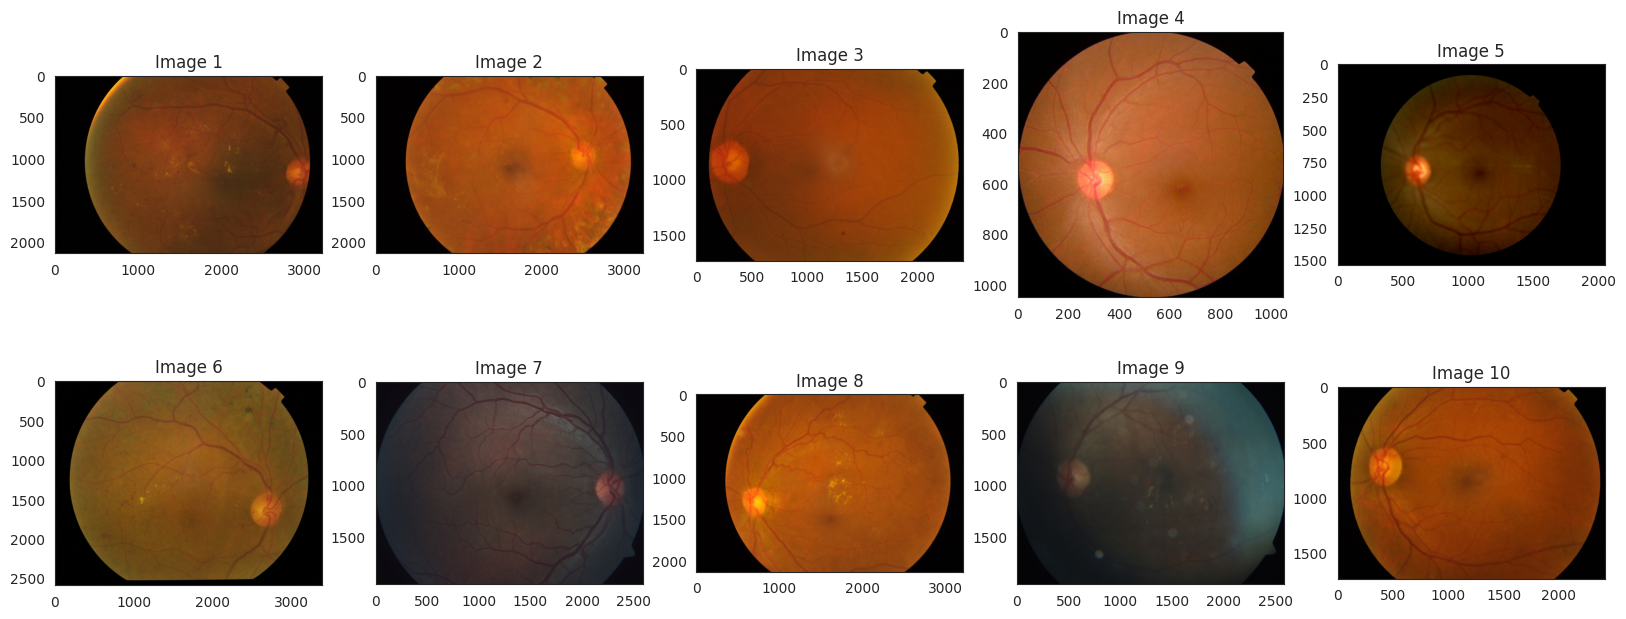

In [ ]:
# 원본 이미지
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

sns.set_style("white")
count = 1
# img_size = 512
plt.figure(figsize=[20, 20])

for img_name in train["id_code"][:10]:
    img = cv2.imread("/content/drive/MyDrive/APOTS_2019/train_images/%s.png" % img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, (img_size, img_size))
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count+=1

plt.show()

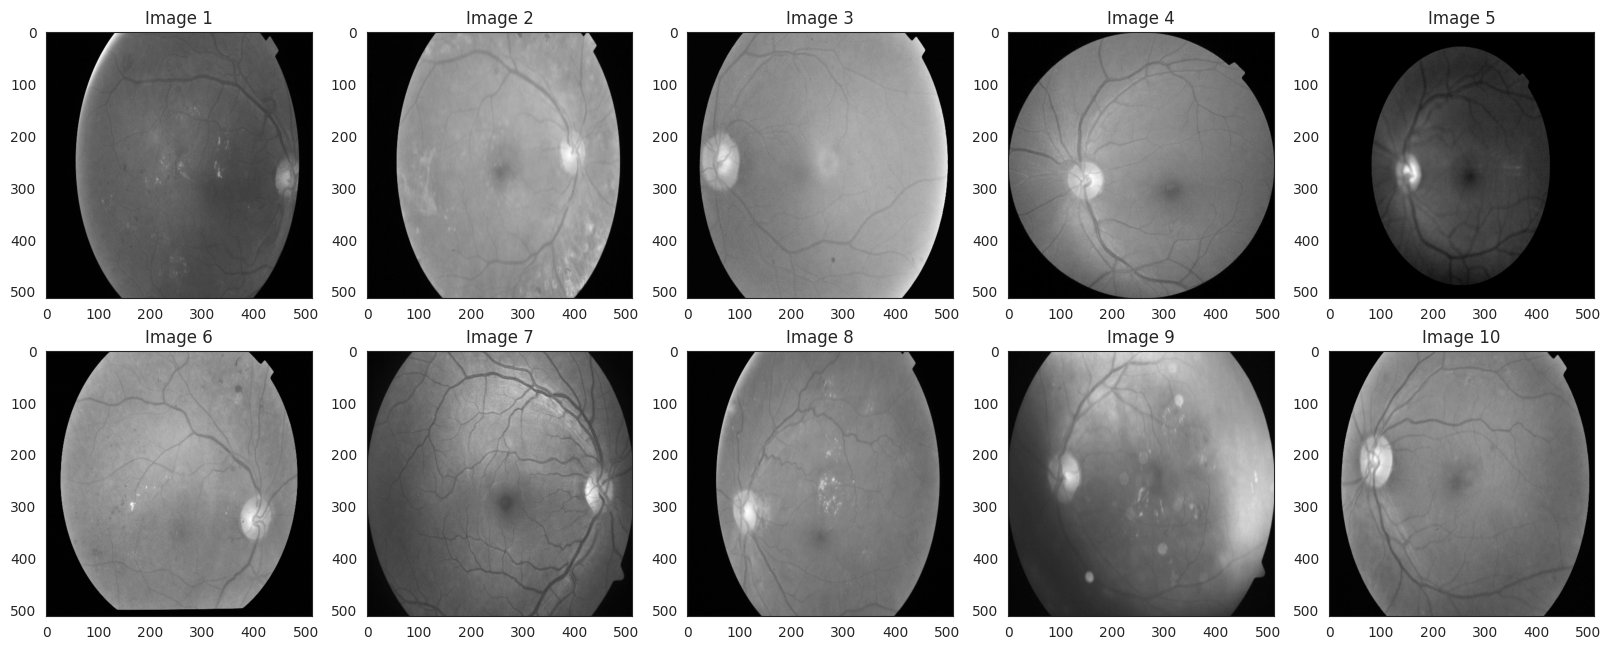

In [ ]:
# 흑백 이미지
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

sns.set_style("white")
count = 1
img_size = 512
plt.figure(figsize=[20, 20])

for img_name in train["id_code"][:10]:
    img = cv2.imread("/content/drive/MyDrive/APOTS_2019/train_images/%s.png" % img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size, img_size))
    plt.subplot(5, 5, count)
    plt.imshow(img, cmap="gray")
    plt.title("Image %s" % count)
    count+=1

plt.show()

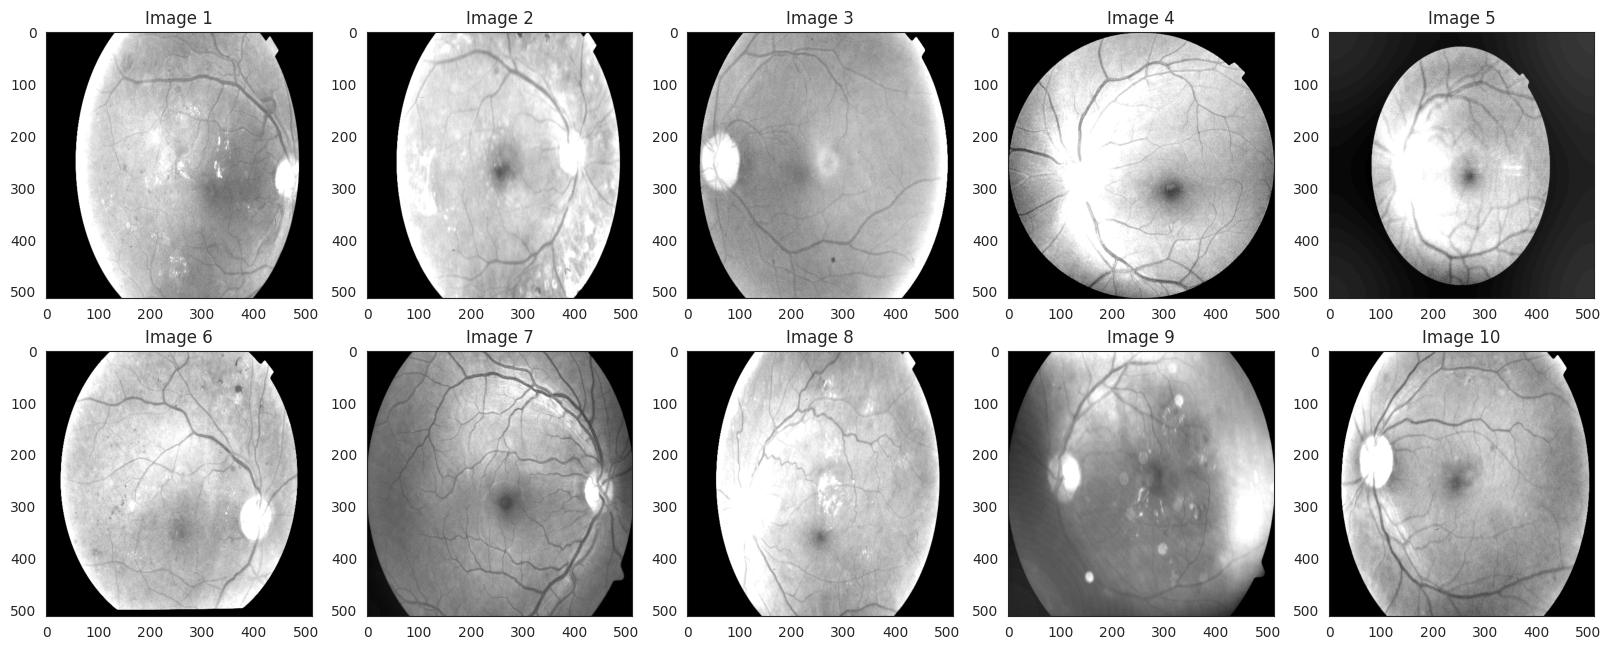

In [ ]:
# GaussianBlur 이미지
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

sns.set_style("white")
count = 1
# img_size = 512
plt.figure(figsize=[20, 20])

for img_name in train["id_code"][:10]:
    img = cv2.imread("/content/drive/MyDrive/APOTS_2019/train_images/%s.png" % img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.resize(img, (img_size, img_size))
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 150.0), -4, 128)
    plt.subplot(5, 5, count)
    plt.imshow(img, cmap="gray")
    plt.title("Image %s" % count)
    count+=1

plt.show()

## Python Keras Ver.  [Reference]

In [ ]:
# Preprocecss data → Data generator
from keras.preprocessing.image import ImageDataGenerator
import cv2

train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train["diagnosis"] = train["diagnosis"].astype("str")

BATCH_SIZE = 8
HEIGHT = 512
WIDTH = 512

train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/APOTS_2019/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset="training")

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/APOTS_2019/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset="validation")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "/content/drive/MyDrive/APOTS_2019/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
# Model
from keras import optimizers, applications
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None,
                                       include_top=False,
                                       input_tensor=input_tensor)
    # base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = base_model.output
    # x = GlobalAveragePooling2D()(base_model.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)

    # model = Model(input_tensor, final_output)
    model = Model(inputs=base_model.input, outputs=final_output)

    return model

WARMUP_LEARNING_RATE = 0.001
N_CLASSES = train["diagnosis"].nunique()
CANAL = 3

model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

In [ ]:
# Train top layers
WARMUP_EPOCHS = 1

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1).history

In [ ]:
# Fine-tune the complete model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

LEARNING_RATE = 0.0001
EPOCHS = 20
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor="val_loss", mode="min", patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor="val_loss", mode="min", patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=0.000001, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=1).history

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'],
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'],
           'acc': history_warmup['acc'] + history_finetunning['acc'],
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}


sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
history2 = {'loss': history_finetunning['loss'],
           'val_loss': history_finetunning['val_loss'],
           'acc': history_finetunning['acc'],
           'val_acc': history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history2['loss'], label='Train loss')
ax1.plot(history2['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history2['acc'], label='Train Accuracy')
ax2.plot(history2['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

print(train_preds[0])
print(train['diagnosis'].tolist()[0])

## PyTorch Ver.  [GPT]



### 훈련 (Train)

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Grayscale, GaussianBlur

# 데이터 전처리 및 경로 설정
train["id_code"] = train["id_code"].apply(lambda x: x + ".png" if not x.endswith(".png") else x)
test["id_code"] = test["id_code"].apply(lambda x: x + ".png" if not x.endswith(".png") else x)
train["diagnosis"] = train["diagnosis"].astype("str")

# GPU 사용 여부 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 및 DataLoader 정의
class ImageDataset(Dataset):
    def __init__(self, dataframe, directory, transform=None):
        self.dataframe = dataframe
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# 하이퍼파라미터 설정
BATCH_SIZE = 8
HEIGHT = 456
WIDTH = 456

# 데이터셋 및 DataLoader 정의
# transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.4138, 0.2210, 0.0737], std=[0.2386, 0.1316, 0.0488])
#                                 ])

# 데이터셋 및 DataLoader 정의
# transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
#                                 transforms.ToTensor(),
#                                 transforms.ColorJitter(brightness=(1.5, 2.0),
#                                 contrast=(1.5, 2.0),
#                                 saturation=(0.2, 0.5),
#                                 hue=(-0.2, 0.2)),
#                                 transforms.Grayscale(num_output_channels=3)
#                                 ])

# 데이터셋 및 DataLoader 정의
transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
                                transforms.ToTensor()
                                ])

# 전체 데이터 중 일부 사용
subset_percentage = 0.2
subset_size = int(len(train) * subset_percentage)
subset_train_dataset = ImageDataset(dataframe=train[:subset_size], directory="/content/drive/MyDrive/APOTS_2019/train_images/", transform=transform)
train_loader = DataLoader(subset_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 전체 데이터 사용
# train_dataset = ImageDataset(dataframe=train, directory="/content/drive/MyDrive/APOTS_2019/train_images/", transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋 및 DataLoader 정의
train_dataset = ImageDataset(dataframe=train, directory="/content/drive/MyDrive/APOTS_2019/train_images/", transform=None)  # 전처리하지 않은 데이터셋
transformed_train_dataset = ImageDataset(dataframe=train, directory="/content/drive/MyDrive/APOTS_2019/train_images/", transform=transform)  # 전처리된 데이터셋

# 샘플 이미지 선택
sample_index = 0
sample_image, _ = train_dataset[sample_index]
transformed_sample_image, _ = transformed_train_dataset[sample_index]

# 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np.array(sample_image))
plt.axis('off')

# 전처리 후 이미지
plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(np.transpose(transformed_sample_image.numpy(), (1, 2, 0)))
plt.axis('off')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import random

# 임의의 10개의 샘플 선택
random_samples = random.sample(range(len(transformed_train_dataset)), 10)

# 시각화
plt.figure(figsize=(15, 7))
for i, idx in enumerate(random_samples, 1):
    image, _ = transformed_train_dataset[idx]

    # 전처리 후 이미지
    plt.subplot(2, 5, i)
    plt.title(f'Sample {i}')
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.axis('off')

plt.show()

In [ ]:
# 데이터셋 및 DataLoader 정의
transform_without_normalize = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
                                                 transforms.ToTensor()
                                                ])

train_dataset_without_normalize = ImageDataset(dataframe=train, directory="/content/drive/MyDrive/APOTS_2019/train_images/", transform=transform_without_normalize)
train_loader_without_normalize = DataLoader(train_dataset_without_normalize, batch_size=BATCH_SIZE, shuffle=True)

# 이미지별로 평균과 표준편차 누적 (20분 소요)
mean = torch.zeros(3)
std = torch.zeros(3)

for inputs, _ in train_loader_without_normalize:
    mean += inputs.mean([2, 3]).sum(0)
    std += inputs.std([2, 3]).sum(0)

# 전체 데이터셋에 대한 평균과 표준편차 계산
mean /= len(train_loader_without_normalize.dataset)
std /= len(train_loader_without_normalize.dataset)

print("평균(RGB):", mean) # 평균(RGB): tensor([0.4138, 0.2210, 0.0737])
print("표준편차(RGB):", std) # 표준편차(RGB): tensor([0.2386, 0.1316, 0.0488])

# 데이터셋 및 DataLoader 재정의
transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=mean.tolist(), std=std.tolist())
                                              ])

train_dataset = ImageDataset(dataframe=train, directory="/content/drive/MyDrive/APOTS_2019/train_images/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

평균(RGB): tensor([0.4138, 0.2210, 0.0737])
표준편차(RGB): tensor([0.2386, 0.1316, 0.0488])


In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# 하이퍼파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 5
N_CLASSES = train["diagnosis"].nunique()

# 모델 정의 (CNN)
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * (HEIGHT // 4) * (WIDTH // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN(N_CLASSES)
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 모델 학습 및 평가
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    data_iterator = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch + 1}")

    for i, data in enumerate(data_iterator, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 에포크 종료 후, 학습 데이터에 대한 평가
    model.eval()
    train_accuracy = 0.0
    train_predictions = []
    train_true_labels = []

    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

    # 학습 데이터에 대한 정확도와 손실 출력
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_average_loss = running_loss / len(train_loader)
    print(f"    Loss: {train_average_loss}, Training Accuracy: {train_accuracy}")

print("----------------------------", "\nFinish Training")

Epoch 1: 100%|██████████| 92/92 [06:58<00:00,  4.55s/it]


    Loss: 1.7018134796425053, Training Accuracy: 0.6857923497267759


Epoch 2: 100%|██████████| 92/92 [01:51<00:00,  1.21s/it]


    Loss: 0.834307170594516, Training Accuracy: 0.7144808743169399


Epoch 3: 100%|██████████| 92/92 [01:52<00:00,  1.22s/it]


    Loss: 0.776913341620694, Training Accuracy: 0.7172131147540983


Epoch 4: 100%|██████████| 92/92 [01:53<00:00,  1.23s/it]


    Loss: 0.7507292744096207, Training Accuracy: 0.7213114754098361


Epoch 5: 100%|██████████| 92/92 [01:51<00:00,  1.21s/it]


    Loss: 0.7772258239919725, Training Accuracy: 0.7281420765027322
---------------------------- 
Finish Training


In [ ]:
from torchvision.models import resnet50

# 하이퍼파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 5
N_CLASSES = train["diagnosis"].nunique()

# 모델 정의 (ResNet-50)
model = resnet50(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, N_CLASSES)
)
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 모델 학습 및 평가
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    data_iterator = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch + 1}")

    for i, data in enumerate(data_iterator, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 에포크 종료 후, 학습 데이터에 대한 평가
    model.eval()
    train_accuracy = 0.0
    train_predictions = []
    train_true_labels = []

    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

    # 학습 데이터에 대한 정확도와 손실 출력
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_average_loss = running_loss / len(train_loader)
    print(f"    Loss: {train_average_loss}, Training Accuracy: {train_accuracy}")

print("----------------------------", "\nFinish Training")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 92/92 [03:01<00:00,  1.98s/it]


    Loss: 1.446328588154005, Training Accuracy: 0.4603825136612022


Epoch 2: 100%|██████████| 92/92 [02:59<00:00,  1.95s/it]


    Loss: 1.4442348169243855, Training Accuracy: 0.4603825136612022


Epoch 3: 100%|██████████| 92/92 [02:57<00:00,  1.93s/it]


    Loss: 1.4442347974880883, Training Accuracy: 0.4603825136612022


Epoch 4: 100%|██████████| 92/92 [02:59<00:00,  1.95s/it]


    Loss: 1.4415174016486043, Training Accuracy: 0.4603825136612022


Epoch 5: 100%|██████████| 92/92 [03:00<00:00,  1.97s/it]


    Loss: 1.444234794896582, Training Accuracy: 0.4603825136612022
---------------------------- 
Finish Training


### 테스트 (Test)

## Python Keras Ver. [도현]

In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/APOTS_2019/train.csv")
train_df["id_code"] = train_df["id_code"].apply(lambda x: x + ".png" if not x.endswith(".png") else x)

test_df = pd.read_csv("/content/drive/MyDrive/APOTS_2019/test.csv")
test_df["id_code"] = test_df["id_code"].apply(lambda x: x + ".png" if not x.endswith(".png") else x)

In [ ]:
import os
import sys

# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras import backend as K
from tensorflow.keras.activations import elu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

KAGGLE_DIR = "/content/drive/MyDrive/APOTS_2019/"
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + "test.csv"
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + "test_images/"

# Specify title of our final model
SAVED_MODEL_NAME = "effnet_modelB5.h5"

# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)  # Updated line
os.environ["PYTHONHASHSEED"] = str(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

In [ ]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    if img.ndim == 2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)

    return image

In [ ]:
# 원본 데이터
from sklearn.model_selection import train_test_split

IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3
BATCH_SIZE = 8

train_df_subset, _ = train_test_split(train_df, train_size=700)

train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.2,
                                   rescale=1/128.)

train_generator = train_datagen.flow_from_dataframe(train_df_subset,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="other",
                                                    subset="training")

val_generator = train_datagen.flow_from_dataframe(train_df_subset,
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="other",
                                                  subset="validation")

Found 560 validated image filenames.
Found 140 validated image filenames.


In [ ]:
# 필터된 데이터
from sklearn.model_selection import train_test_split

IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3
BATCH_SIZE = 8

train_df_subset, _ = train_test_split(train_df, train_size=700)

train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.2,
                                   preprocessing_function=preprocess_image,
                                   rescale=1/128.)

train_generator = train_datagen.flow_from_dataframe(train_df_subset,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="other",
                                                    subset="training")

val_generator = train_datagen.flow_from_dataframe(train_df_subset,
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="other",
                                                  subset="validation")

Found 560 validated image filenames.
Found 140 validated image filenames.


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
70/70 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.6250
Epoch 1: val_loss improved from inf to 1.53429, saving model to effnet_modelB5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 378s 5s/step - loss: 1.0886 - accuracy: 0.6250 - val_loss: 1.5343 - val_accuracy: 0.5074
Epoch 2/5
70/70 [==============================] - ETA: 0s - loss: 0.8522 - accuracy: 0.7000
Epoch 2: val_loss improved from 1.53429 to 1.27646, saving model to effnet_modelB5.h5
70/70 [==============================] - 126s 2s/step - loss: 0.8522 - accuracy: 0.7000 - val_loss: 1.2765 - val_accuracy: 0.4853
Epoch 3/5
70/70 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7268
Epoch 3: val_loss did not improve from 1.27646
70/70 [==============================] - 141s 2s/step - loss: 0.7310 - accuracy: 0.7268 - val_loss: 1.8190 - val_accuracy: 0.4853
Epoch 4/5
70/70 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.7482
Epoch 4: val_loss did not improve from 1.27646
70/70 [==============================] - 118s 2s/step - loss: 0.6594 - accuracy: 0.7482 - val_loss: 1.5736 - val_accuracy: 0.4853
Epoch 5/5
70/70 [====

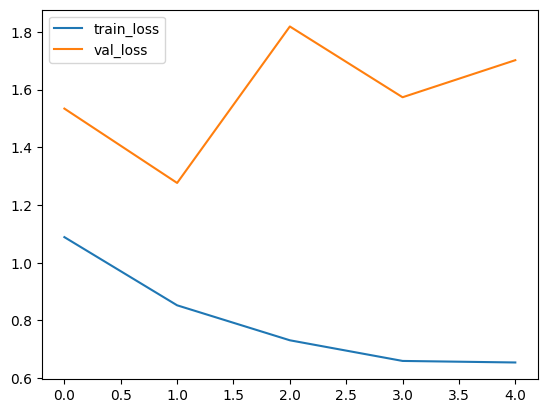

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ResNet 모델 정의
def resnet_model(n_out=5):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(n_out, activation="softmax"))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

# 모델 빌드 및 컴파일
resnet_model = resnet_model()

# 콜백 함수 정의
checkpoint = ModelCheckpoint(SAVED_MODEL_NAME, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=1)

# 모델 훈련
history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

# 훈련 이력 시각화
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

# 최상의 모델 불러오기
resnet_model.load_weights(SAVED_MODEL_NAME)

Epoch 1/5
70/70 [==============================] - ETA: 0s - loss: 1.4770 - accuracy: 0.5393
Epoch 1: val_loss improved from inf to 0.86399, saving model to effnet_modelB5.h5
70/70 [==============================] - 136s 2s/step - loss: 1.4770 - accuracy: 0.5393 - val_loss: 0.8640 - val_accuracy: 0.6618
Epoch 2/5
70/70 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.6857
Epoch 2: val_loss improved from 0.86399 to 0.83690, saving model to effnet_modelB5.h5
70/70 [==============================] - 152s 2s/step - loss: 0.9064 - accuracy: 0.6857 - val_loss: 0.8369 - val_accuracy: 0.7059
Epoch 3/5
70/70 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.7143
Epoch 3: val_loss improved from 0.83690 to 0.80057, saving model to effnet_modelB5.h5
70/70 [==============================] - 154s 2s/step - loss: 0.8406 - accuracy: 0.7143 - val_loss: 0.8006 - val_accuracy: 0.7279
Epoch 4/5
70/70 [==============================] - ETA: 0s - loss: 0.8163 - a

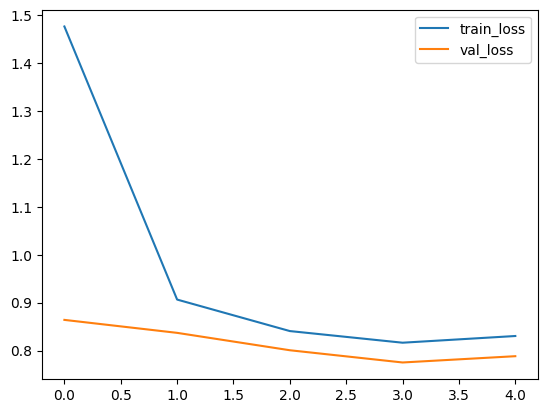

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def cnn_model(n_out=5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(n_out, activation="softmax"))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

# 모델 빌드 및 컴파일
cnn_model = cnn_model()

# 콜백 함수 정의
checkpoint = ModelCheckpoint(SAVED_MODEL_NAME, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=1)

# 모델 훈련
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

# 훈련 이력 시각화
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

# 최상의 모델 불러오기
cnn_model.load_weights(SAVED_MODEL_NAME)

In [ ]:
# 테스트 세트에서 평가
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image, rescale=1/128.)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="id_code",
    directory=TEST_IMG_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# 테스트 세트에 대한 예측 얻기
test_preds = resnet_model.predict(test_generator)

# 예측 결과를 CSV 파일로 저장하거나 필요한 대로 사용하세요
test_df["diagnosis"] = test_preds
test_df.to_csv("resnet_predictions.csv", index=False)